# ExoPredict-Classifying-and-Predicting-Exoplanet-Characteristics

# Extract
1. Initialize a PySpark session to handle big data efficiently.
2. Read the files containing exoplanet data.


In [1]:
import os
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.osuosl.org/spark/spark-3.5.4/spark-3.5.4-bin-hadoop3.tgz
!tar xf spark-3.5.4-bin-hadoop3.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.4-bin-hadoop3"

In [14]:
# Import findspark and initialise.
import findspark
findspark.init()

In [15]:
from google.colab import files
uploaded = files.upload()

Saving PS_2025.02.03_02.08.19.csv to PS_2025.02.03_02.08.19 (1).csv


In [16]:
# Import packages
from pyspark.sql import SparkSession
import time

# Create a SparkSession
spark = SparkSession.builder.appName("ExoPlanet_ETL_Project").getOrCreate()

In [17]:
# Read the file
file_path = "/content/PS_2025.02.03_02.08.19.csv"

df = spark.read.option("header", "true").option("inferSchema", "true").csv(file_path)
df.show(5)

+----------+--------+------------+-------+-------+---------------+---------+--------------------+-------------------+---------------+--------------------+---------+-------------+-------------+------------+----------+--------------+--------------+-------------+-------+-----------+-----------+----------+-------+-----------+-----------+----------+----------+-------------+-------------+------------+---------+-------------+-------------+------------+------------+-----------+---------------+---------------+--------------+--------+------------+------------+-----------+------+----------+----------+---------+--------+--------------------+-----------+-------+-----------+-----------+----------+------+----------+----------+---------+-------+-----------+-----------+----------+------+----------+----------+---------+-----------+-------+-----------+-----------+----------+--------------------+------------+-----------+-------------+----------+-------+-----------+-----------+-------+-----------+---------

# Transform
1. Drop unnecessary columns – A new dataframe is created with only the required columns.
2. Remove columns with excessive missing values to improve data quality.
3. Change column data types where necessary for consistency and accuracy.
4. Rename columns for better readability and ease of use.
5. Standardize numerical columns using feature scaling (important for ML models).
6. Create a unique identifier to set as an index for efficient querying.
7. Export the cleaned data for further analysis.

In [18]:
# Data Selection
df = df.select("pl_name", "hostname", "discoverymethod", "disc_year", "disc_facility", "pl_refname", "pl_orbper", "pl_orbpererr1", "pl_orbpererr2", "pl_orbsmax", "pl_rade", "pl_radj","pl_bmasse", "pl_bmassj", "pl_bmassprov", "pl_orbeccen", "pl_insol", "pl_eqt", "pl_eqterr1", "pl_eqterr2", "pl_eqtlim", "ttv_flag", "st_refname", "st_spectype", "st_teff", "st_tefferr1", "st_tefferr2", "st_tefflim", "st_rad", "st_mass", "st_met", "st_logg", "sy_refname", "rastr", "ra", "dec", "sy_dist", "sy_vmag", "sy_kmag")
df.show(5)

+----------+--------+---------------+---------+--------------------+--------------------+---------+-------------+-------------+----------+-------+-------+----------+---------+------------+-----------+--------+------+----------+----------+---------+--------+--------------------+-----------+-------+-----------+-----------+----------+------+-------+------+-------+--------------------+------------+-----------+----------+-------+-------+-------+
|   pl_name|hostname|discoverymethod|disc_year|       disc_facility|          pl_refname|pl_orbper|pl_orbpererr1|pl_orbpererr2|pl_orbsmax|pl_rade|pl_radj| pl_bmasse|pl_bmassj|pl_bmassprov|pl_orbeccen|pl_insol|pl_eqt|pl_eqterr1|pl_eqterr2|pl_eqtlim|ttv_flag|          st_refname|st_spectype|st_teff|st_tefferr1|st_tefferr2|st_tefflim|st_rad|st_mass|st_met|st_logg|          sy_refname|       rastr|         ra|       dec|sy_dist|sy_vmag|sy_kmag|
+----------+--------+---------------+---------+--------------------+--------------------+---------+-----------

In [28]:
# Import necessary libraries
from pyspark.sql.functions import col, mean, when, lit, count, round
from pyspark.sql.types import IntegerType, DoubleType, DateType

In [29]:
# Total Rows
total_rows = df.count()
print(f"Total Rows: {total_rows}")

Total Rows: 1130


In [30]:
# Count missing values per column
missing_counts = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])

# Show missing values
missing_counts.show()

+-------+--------+---------------+---------+-------------+----------+---------+-------------+-------------+----------+-------+-------+---------+---------+------------+-----------+--------+------+----------+----------+---------+--------+----------+-----------+-------+-----------+-----------+----------+------+-------+------+-------+----------+-----+---+---+-------+-------+-------+
|pl_name|hostname|discoverymethod|disc_year|disc_facility|pl_refname|pl_orbper|pl_orbpererr1|pl_orbpererr2|pl_orbsmax|pl_rade|pl_radj|pl_bmasse|pl_bmassj|pl_bmassprov|pl_orbeccen|pl_insol|pl_eqt|pl_eqterr1|pl_eqterr2|pl_eqtlim|ttv_flag|st_refname|st_spectype|st_teff|st_tefferr1|st_tefferr2|st_tefflim|st_rad|st_mass|st_met|st_logg|sy_refname|rastr| ra|dec|sy_dist|sy_vmag|sy_kmag|
+-------+--------+---------------+---------+-------------+----------+---------+-------------+-------------+----------+-------+-------+---------+---------+------------+-----------+--------+------+----------+----------+---------+--------+

In [31]:
#Drop columns with too many missing values (e.g., >50%)
threshold = int(0.5 * df.count())
df_cleaned = df.dropna(thresh=threshold)
df_cleaned .show(5)

+-------+--------+---------------+---------+-------------+----------+---------+-------------+-------------+----------+-------+-------+---------+---------+------------+-----------+--------+------+----------+----------+---------+--------+----------+-----------+-------+-----------+-----------+----------+------+-------+------+-------+----------+-----+---+---+-------+-------+-------+
|pl_name|hostname|discoverymethod|disc_year|disc_facility|pl_refname|pl_orbper|pl_orbpererr1|pl_orbpererr2|pl_orbsmax|pl_rade|pl_radj|pl_bmasse|pl_bmassj|pl_bmassprov|pl_orbeccen|pl_insol|pl_eqt|pl_eqterr1|pl_eqterr2|pl_eqtlim|ttv_flag|st_refname|st_spectype|st_teff|st_tefferr1|st_tefferr2|st_tefflim|st_rad|st_mass|st_met|st_logg|sy_refname|rastr| ra|dec|sy_dist|sy_vmag|sy_kmag|
+-------+--------+---------------+---------+-------------+----------+---------+-------------+-------------+----------+-------+-------+---------+---------+------------+-----------+--------+------+----------+----------+---------+--------+

In [32]:
#Fill missing categorical values with "Unknown"
for c in df.columns:
    df = df.fillna({c: "Unknown"})

In [33]:
#Convert Data types
from pyspark.sql.types import IntegerType, DoubleType, DateType

df = df.withColumn("disc_year", col("disc_year").cast(IntegerType()))


In [34]:
#Remove Duplicates
df = df.dropDuplicates()
df.show(2)

+-----------+---------+---------------+---------+--------------------+--------------------+----------+-------------+-------------+----------+-------+-------+---------+---------+------------+-----------+--------+------+----------+----------+---------+--------+--------------------+-----------+-------+-----------+-----------+----------+------+-------+------+-------+--------------------+------------+-----------+-----------+-------+-------+-------+
|    pl_name| hostname|discoverymethod|disc_year|       disc_facility|          pl_refname| pl_orbper|pl_orbpererr1|pl_orbpererr2|pl_orbsmax|pl_rade|pl_radj|pl_bmasse|pl_bmassj|pl_bmassprov|pl_orbeccen|pl_insol|pl_eqt|pl_eqterr1|pl_eqterr2|pl_eqtlim|ttv_flag|          st_refname|st_spectype|st_teff|st_tefferr1|st_tefferr2|st_tefflim|st_rad|st_mass|st_met|st_logg|          sy_refname|       rastr|         ra|        dec|sy_dist|sy_vmag|sy_kmag|
+-----------+---------+---------------+---------+--------------------+--------------------+----------+--

In [35]:
# Define columns to check for outliers
outlier_cols = ["pl_rade", "pl_bmasse", "st_teff"]

# Remove outliers based on the 1st and 99th percentile
for col_name in outlier_cols:
    lower, upper = df.approxQuantile(col_name, [0.01, 0.99], 0)  # Compute quantiles
    df = df.filter((col(col_name) >= lower) & (col(col_name) <= upper))

df.show(5)

+-----------+---------+---------------+---------+--------------------+--------------------+---------+-------------+-------------+----------+-------+-------+----------+---------+------------+-----------+--------+------+----------+----------+---------+--------+--------------------+-----------+-------+-----------+-----------+----------+------+-------+------+-------+--------------------+------------+-----------+-----------+-------+-------+-------+
|    pl_name| hostname|discoverymethod|disc_year|       disc_facility|          pl_refname|pl_orbper|pl_orbpererr1|pl_orbpererr2|pl_orbsmax|pl_rade|pl_radj| pl_bmasse|pl_bmassj|pl_bmassprov|pl_orbeccen|pl_insol|pl_eqt|pl_eqterr1|pl_eqterr2|pl_eqtlim|ttv_flag|          st_refname|st_spectype|st_teff|st_tefferr1|st_tefferr2|st_tefflim|st_rad|st_mass|st_met|st_logg|          sy_refname|       rastr|         ra|        dec|sy_dist|sy_vmag|sy_kmag|
+-----------+---------+---------------+---------+--------------------+--------------------+---------+---

In [38]:
# count columns
column_count = len(df.columns)
print("Number of columns:", column_count)


Number of columns: 39


In [39]:
#Check the Data Types for each Column in a DataFrame
df_types = spark.createDataFrame(df.dtypes, ["Column", "DataType"])
df_types.show(truncate=False)

+---------------+--------+
|Column         |DataType|
+---------------+--------+
|pl_name        |string  |
|hostname       |string  |
|discoverymethod|string  |
|disc_year      |int     |
|disc_facility  |string  |
|pl_refname     |string  |
|pl_orbper      |double  |
|pl_orbpererr1  |double  |
|pl_orbpererr2  |double  |
|pl_orbsmax     |double  |
|pl_rade        |double  |
|pl_radj        |double  |
|pl_bmasse      |double  |
|pl_bmassj      |double  |
|pl_bmassprov   |string  |
|pl_orbeccen    |double  |
|pl_insol       |double  |
|pl_eqt         |int     |
|pl_eqterr1     |int     |
|pl_eqterr2     |int     |
+---------------+--------+
only showing top 20 rows



In [40]:
#disc_year should be a proper Date not int
from pyspark.sql.functions import to_date, concat_ws, lit

# Convert disc_year (int) to a proper date format
df = df.withColumn("disc_date", to_date(concat_ws("-", col("disc_year").cast("string"), lit("01"), lit("01")), "yyyy-MM-dd"))

# Verify the updated schema
df.select("disc_year", "disc_date").show(5)
df.printSchema()

+---------+----------+
|disc_year| disc_date|
+---------+----------+
|     2019|2019-01-01|
|     2019|2019-01-01|
|     2023|2023-01-01|
|     2015|2015-01-01|
|     2020|2020-01-01|
+---------+----------+
only showing top 5 rows

root
 |-- pl_name: string (nullable = false)
 |-- hostname: string (nullable = false)
 |-- discoverymethod: string (nullable = false)
 |-- disc_year: integer (nullable = true)
 |-- disc_facility: string (nullable = false)
 |-- pl_refname: string (nullable = false)
 |-- pl_orbper: double (nullable = true)
 |-- pl_orbpererr1: double (nullable = true)
 |-- pl_orbpererr2: double (nullable = true)
 |-- pl_orbsmax: double (nullable = true)
 |-- pl_rade: double (nullable = true)
 |-- pl_radj: double (nullable = true)
 |-- pl_bmasse: double (nullable = true)
 |-- pl_bmassj: double (nullable = true)
 |-- pl_bmassprov: string (nullable = false)
 |-- pl_orbeccen: double (nullable = true)
 |-- pl_insol: double (nullable = true)
 |-- pl_eqt: integer (nullable = true)
 |-

In [43]:
# Count null values per column
missing_counts = df.select([count(when(col(c).isNull(), 1)).alias(c) for c in df.columns])
missing_counts.show()


+-------+--------+---------------+---------+-------------+----------+---------+-------------+-------------+----------+-------+-------+---------+---------+------------+-----------+------+----------+----------+---------+--------+----------+-----------+-------+-----------+-----------+----------+------+-------+------+-------+----------+-----+---+---+-------+-------+-------+---------+
|pl_name|hostname|discoverymethod|disc_year|disc_facility|pl_refname|pl_orbper|pl_orbpererr1|pl_orbpererr2|pl_orbsmax|pl_rade|pl_radj|pl_bmasse|pl_bmassj|pl_bmassprov|pl_orbeccen|pl_eqt|pl_eqterr1|pl_eqterr2|pl_eqtlim|ttv_flag|st_refname|st_spectype|st_teff|st_tefferr1|st_tefferr2|st_tefflim|st_rad|st_mass|st_met|st_logg|sy_refname|rastr| ra|dec|sy_dist|sy_vmag|sy_kmag|disc_date|
+-------+--------+---------------+---------+-------------+----------+---------+-------------+-------------+----------+-------+-------+---------+---------+------------+-----------+------+----------+----------+---------+--------+-------

In [44]:
# Get columns where more than 50% values are missing
cols_to_drop = [c for c in df.columns if df.select(count(when(col(c).isNull(), 1)) / total_rows).collect()[0][0] > 0.5]

# Drop those columns
df = df.drop(*cols_to_drop)

df.show(5)

+-----------+---------+---------------+---------+--------------------+--------------------+---------+-------------+-------------+----------+-------+-------+----------+---------+------------+-----------+------+----------+----------+---------+--------+--------------------+-----------+-------+-----------+-----------+----------+------+-------+------+-------+--------------------+------------+-----------+-----------+-------+-------+-------+----------+
|    pl_name| hostname|discoverymethod|disc_year|       disc_facility|          pl_refname|pl_orbper|pl_orbpererr1|pl_orbpererr2|pl_orbsmax|pl_rade|pl_radj| pl_bmasse|pl_bmassj|pl_bmassprov|pl_orbeccen|pl_eqt|pl_eqterr1|pl_eqterr2|pl_eqtlim|ttv_flag|          st_refname|st_spectype|st_teff|st_tefferr1|st_tefferr2|st_tefflim|st_rad|st_mass|st_met|st_logg|          sy_refname|       rastr|         ra|        dec|sy_dist|sy_vmag|sy_kmag| disc_date|
+-----------+---------+---------------+---------+--------------------+--------------------+---------

In [45]:
column_count = len(df.columns)
print("Number of columns:", column_count)

Number of columns: 39


In [46]:
#Drop Rows where key Columns are missing
df = df.dropna(subset=["pl_name", "hostname"])
df.show(5)

+-----------+---------+---------------+---------+--------------------+--------------------+---------+-------------+-------------+----------+-------+-------+----------+---------+------------+-----------+------+----------+----------+---------+--------+--------------------+-----------+-------+-----------+-----------+----------+------+-------+------+-------+--------------------+------------+-----------+-----------+-------+-------+-------+----------+
|    pl_name| hostname|discoverymethod|disc_year|       disc_facility|          pl_refname|pl_orbper|pl_orbpererr1|pl_orbpererr2|pl_orbsmax|pl_rade|pl_radj| pl_bmasse|pl_bmassj|pl_bmassprov|pl_orbeccen|pl_eqt|pl_eqterr1|pl_eqterr2|pl_eqtlim|ttv_flag|          st_refname|st_spectype|st_teff|st_tefferr1|st_tefferr2|st_tefflim|st_rad|st_mass|st_met|st_logg|          sy_refname|       rastr|         ra|        dec|sy_dist|sy_vmag|sy_kmag| disc_date|
+-----------+---------+---------------+---------+--------------------+--------------------+---------

In [47]:
# Fill missing numerical values with Mean
from pyspark.sql.functions import mean

num_cols = [c for c, dtype in df.dtypes if dtype in ("int", "double")]

for c in num_cols:
    mean_value = df.select(mean(col(c))).collect()[0][0]
    if mean_value is not None:
        df = df.fillna({c: mean_value})

df.show(5)

+-----------+---------+---------------+---------+--------------------+--------------------+---------+-------------+-------------+----------+-------+-------+----------+---------+------------+-----------+------+----------+----------+---------+--------+--------------------+-----------+-------+-----------+-----------+----------+------+-------+------+-------+--------------------+------------+-----------+-----------+-------+-------+-------+----------+
|    pl_name| hostname|discoverymethod|disc_year|       disc_facility|          pl_refname|pl_orbper|pl_orbpererr1|pl_orbpererr2|pl_orbsmax|pl_rade|pl_radj| pl_bmasse|pl_bmassj|pl_bmassprov|pl_orbeccen|pl_eqt|pl_eqterr1|pl_eqterr2|pl_eqtlim|ttv_flag|          st_refname|st_spectype|st_teff|st_tefferr1|st_tefferr2|st_tefflim|st_rad|st_mass|st_met|st_logg|          sy_refname|       rastr|         ra|        dec|sy_dist|sy_vmag|sy_kmag| disc_date|
+-----------+---------+---------------+---------+--------------------+--------------------+---------

In [48]:
#count the Rows with any NULL or Empty values
df.select(count(when(
    col(c).isNull() | (col(c) == ""), 1
)).alias("Rows_with_missing_values")).show()

+------------------------+
|Rows_with_missing_values|
+------------------------+
|                       0|
+------------------------+



In [49]:
# show the Rows that contain NULL or Empty Strings
df.filter(
    (col("pl_name").isNull()) | (col("pl_name") == "")
).show()

+-------+--------+---------------+---------+-------------+----------+---------+-------------+-------------+----------+-------+-------+---------+---------+------------+-----------+------+----------+----------+---------+--------+----------+-----------+-------+-----------+-----------+----------+------+-------+------+-------+----------+-----+---+---+-------+-------+-------+---------+
|pl_name|hostname|discoverymethod|disc_year|disc_facility|pl_refname|pl_orbper|pl_orbpererr1|pl_orbpererr2|pl_orbsmax|pl_rade|pl_radj|pl_bmasse|pl_bmassj|pl_bmassprov|pl_orbeccen|pl_eqt|pl_eqterr1|pl_eqterr2|pl_eqtlim|ttv_flag|st_refname|st_spectype|st_teff|st_tefferr1|st_tefferr2|st_tefflim|st_rad|st_mass|st_met|st_logg|sy_refname|rastr| ra|dec|sy_dist|sy_vmag|sy_kmag|disc_date|
+-------+--------+---------------+---------+-------------+----------+---------+-------------+-------------+----------+-------+-------+---------+---------+------------+-----------+------+----------+----------+---------+--------+-------

In [50]:
#Columns Names
df.columns

['pl_name',
 'hostname',
 'discoverymethod',
 'disc_year',
 'disc_facility',
 'pl_refname',
 'pl_orbper',
 'pl_orbpererr1',
 'pl_orbpererr2',
 'pl_orbsmax',
 'pl_rade',
 'pl_radj',
 'pl_bmasse',
 'pl_bmassj',
 'pl_bmassprov',
 'pl_orbeccen',
 'pl_eqt',
 'pl_eqterr1',
 'pl_eqterr2',
 'pl_eqtlim',
 'ttv_flag',
 'st_refname',
 'st_spectype',
 'st_teff',
 'st_tefferr1',
 'st_tefferr2',
 'st_tefflim',
 'st_rad',
 'st_mass',
 'st_met',
 'st_logg',
 'sy_refname',
 'rastr',
 'ra',
 'dec',
 'sy_dist',
 'sy_vmag',
 'sy_kmag',
 'disc_date']

In [51]:
# Rename Columns in PySpark
df = df.withColumnRenamed("pl_name", "Planet_Name") \
       .withColumnRenamed("hostname", "Host_Star") \
       .withColumnRenamed("discoverymethod", "Discovery_Method") \
       .withColumnRenamed("disc_year", "Discovery_Year") \
       .withColumnRenamed("disc_facility", "Discovery_Facility") \
       .withColumnRenamed("pl_refname", "Reference_Name") \
       .withColumnRenamed("pl_orbper", "Orbital_Period_Days") \
       .withColumnRenamed("pl_orbpererr1", "Orbital_Period_Error_Upper") \
       .withColumnRenamed("pl_orbpererr2", "Orbital_Period_Error_Lower") \
       .withColumnRenamed("pl_orbsmax", "Semi_Major_Axis_AU") \
       .withColumnRenamed("pl_rade", "Planet_Radius_Earth") \
       .withColumnRenamed("pl_bmasse", "Planet_Mass_Earth") \
       .withColumnRenamed("pl_orbeccen", "Orbital_Eccentricity") \
       .withColumnRenamed("pl_eqt", "Equilibrium_Temperature") \
       .withColumnRenamed("pl_eqterr1", "UEB_temp") \
       .withColumnRenamed("pl_eqterr2", "LEB_temp") \
       .withColumnRenamed("st_teff", "Star_Temperature_K") \
       .withColumnRenamed("st_tefferr1", "Star_UEBTemp") \
       .withColumnRenamed("st_tefferr1", "Star_LEBTemp") \
       .withColumnRenamed("st_rad", "Star_Radius_Solar") \
       .withColumnRenamed("st_mass", "Star_Mass_Solar") \
       .withColumnRenamed("st_met", "Star_Metallicity") \
       .withColumnRenamed("st_logg", "Star_Surface_Gravity") \
       .withColumnRenamed("sy_dist", "System_Distance_PC") \
       .withColumnRenamed("sy_vmag", "System_Visual_Magnitude") \
       .withColumnRenamed("sy_kmag", "System_Infrared_Magnitude") \
       .withColumnRenamed("disc_date", "Discovery_Date")

In [52]:
#verify Renamed Columns
df.show()

+------------+----------+----------------+--------------+--------------------+--------------------+-------------------+--------------------------+--------------------------+------------------+-------------------+-------+-----------------+---------+------------+--------------------+-----------------------+--------+--------+---------+--------+--------------------+-----------+------------------+------------+-----------+----------+-----------------+---------------+----------------+--------------------+--------------------+------------+-----------+-----------+------------------+-----------------------+-------------------------+--------------+
| Planet_Name| Host_Star|Discovery_Method|Discovery_Year|  Discovery_Facility|      Reference_Name|Orbital_Period_Days|Orbital_Period_Error_Upper|Orbital_Period_Error_Lower|Semi_Major_Axis_AU|Planet_Radius_Earth|pl_radj|Planet_Mass_Earth|pl_bmassj|pl_bmassprov|Orbital_Eccentricity|Equilibrium_Temperature|UEB_temp|LEB_temp|pl_eqtlim|ttv_flag|          s

In [53]:
# Standardize Numerical Columns (Feature Scaling for ML Models)
from pyspark.ml.feature import StandardScaler, VectorAssembler

# Define numerical columns to scale
num_features = ["Planet_Radius_Earth", "Planet_Mass_Earth", "Star_Temperature_K"]

# Step 1: Assemble features into a single vector column
assembler = VectorAssembler(inputCols=num_features, outputCol="features")
df_transformed = assembler.transform(df)  # Apply transformation and create "features" column

# Step 2: Apply StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
scaler_model = scaler.fit(df_transformed)  # Fit scaler model
df_scaled = scaler_model.transform(df_transformed)  # Transform data

# Show the final dataset with the new scaled features
df_scaled.select("features", "scaled_features").show(truncate=False)

+-------------------------+---------------------------------------------------------------+
|features                 |scaled_features                                                |
+-------------------------+---------------------------------------------------------------+
|[1.664,4.72,5664.0]      |[-1.2367138401358524,-0.6342530295009698,0.3419853089950716]   |
|[2.63,24.5,5725.0]       |[-1.0568758328295873,-0.5842131623797241,0.42052590314308713]  |
|[2.91,1112.39942,5592.0] |[-1.0047488741900903,2.167978061992385,0.24928165688593854]    |
|[1.458,2.2,3844.0]       |[-1.2750643882777681,-0.6406281794072155,-2.0013570082080148]  |
|[14.415,375.0394,5404.0] |[1.1371106227649603,0.3025889102573443,0.0072221208232021595]  |
|[1.533,3.09,3803.0]      |[-1.26110181007076,-0.6383766383688986,-2.054146587881271]     |
|[2.69,9.13,4580.0]       |[-1.045705770263981,-0.6230965171650399,-1.0537196755368765]   |
|[2.73,14.3,4285.0]       |[-1.0382590618869099,-0.6100173405716708,-1.433547139

In [59]:
# Drop existing indexed columns if they exist
for col_name in ["Discovery_Method_Index", "Discovery_Facility_Index"]:
    if col_name in df.columns:
        df = df.drop(col_name)

In [60]:
# Encode categorical variables (for ML)
from pyspark.ml.feature import StringIndexer

categorical_cols = ["Discovery_Method", "Discovery_Facility"]

for col_name in categorical_cols:
    indexer = StringIndexer(inputCol=col_name, outputCol=col_name + "_Index")
    df = indexer.fit(df).transform(df)

df.show(5)

+-----------+---------+----------------+--------------+--------------------+--------------------+-------------------+--------------------------+--------------------------+------------------+-------------------+-------+-----------------+---------+------------+--------------------+-----------------------+--------+--------+---------+--------+--------------------+-----------+------------------+------------+-----------+----------+-----------------+---------------+----------------+--------------------+--------------------+------------+-----------+-----------+------------------+-----------------------+-------------------------+--------------+----------------------+------------------------+
|Planet_Name|Host_Star|Discovery_Method|Discovery_Year|  Discovery_Facility|      Reference_Name|Orbital_Period_Days|Orbital_Period_Error_Upper|Orbital_Period_Error_Lower|Semi_Major_Axis_AU|Planet_Radius_Earth|pl_radj|Planet_Mass_Earth|pl_bmassj|pl_bmassprov|Orbital_Eccentricity|Equilibrium_Temperature|UEB_

# Export

In [62]:
# Save the fully cleaned Dataset
df.write.csv("Cleaned_Dataset.csv", header=True)



# Load
## Dats Analysis

In [69]:
# Import necessary libraries
from pyspark.sql.types import IntegerType, DoubleType, DateType
from pyspark.sql.functions import col, isnan, when, count, monotonically_increasing_id
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.ml.clustering import KMeans
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [70]:
# cache the cleaned dataset
clean_df = df.cache()
clean_df.show(2)

+-----------+---------+----------------+--------------+------------------+--------------------+-------------------+--------------------------+--------------------------+-------------------+-------------------+-------+-----------------+---------+------------+--------------------+-----------------------+--------+--------+---------+--------+--------------------+-----------+------------------+-----------------+------------------+----------+-----------------+---------------+--------------------+--------------------+--------------------+------------+-----------+----------+------------------+-----------------------+-------------------------+--------------+----------------------+------------------------+
|Planet_Name|Host_Star|Discovery_Method|Discovery_Year|Discovery_Facility|      Reference_Name|Orbital_Period_Days|Orbital_Period_Error_Upper|Orbital_Period_Error_Lower| Semi_Major_Axis_AU|Planet_Radius_Earth|pl_radj|Planet_Mass_Earth|pl_bmassj|pl_bmassprov|Orbital_Eccentricity|Equilibrium_Tem

#### Data Analysis
 1. How do planetary characteristics influence the likelihood of being in the habitable zone? (Mandeep)
 2. How does a planet’s orbit impact its temperature and potential habitability?(Mandeep)

In [ ]:
# Habitability Analysis based upon temperature and orbit
df_habitable = df.select('semi_major_axis', 'temperature', 'Default_Flag')

#Convert to Pandas for Visualisation
df_habitable_pd = df_habitable.toPandas()

sns.scatterplot(data=df_habitable_pd, x='semi_major_axis', y='temperature', hue='Default_Flag')
plt.xlabel("Semi-Major Axis")
plt.ylabel("Temperature")
plt.title("Habitability Analysis")
plt.savefig("habitability_analysis.png")
plt.show()

#Save the Results
df_habitable_pd.to_csv("habitability_analysis.csv", index=False)

In [ ]:
# --- Question 3 & 4: Classification by Insolation, Temperature, Mass, Coordinates ---
df_class2 = df.select('Insolation_Flux', 'temperature', 'mass', 'ra', 'dec')

#Convert to Pandas for Visualisation
df_class2_pd = df_class2.toPandas()
sns.pairplot(df_class2_pd)
plt.savefig("classification_insolation_temp_mass_coordinates.png")
plt.show()

#Save the Results
df_class2.toPandas().to_csv("classification_insolation_temp_mass_coordinates.csv", index=False)

+------------+----------+
| Planet_Name|prediction|
+------------+----------+
|  CoRoT-23 b|         1|
| Kepler-52 b|         0|
|      XO-1 b|         1|
| HD 136352 b|         0|
|   CoRoT-4 b|         1|
|    K2-233 c|         0|
| KOI-1783.02|         0|
|Kepler-117 c|         2|
| Kepler-19 b|         0|
| Kepler-37 d|         0|
+------------+----------+
only showing top 10 rows



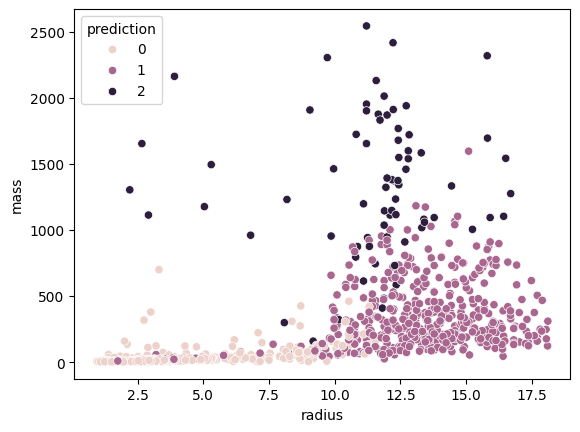

In [71]:
# --- Question 1: Clustering Exoplanets ---
df = df.withColumnRenamed("Planet_Radius_Earth", "radius").withColumnRenamed("Planet_Mass_Earth", "mass").withColumnRenamed("Equilibrium_Temperature", "temperature").withColumnRenamed("Semi_Major_Axis_AU", "semi_major_axis")

features = ['radius', 'mass', 'temperature', 'semi_major_axis']
vector_assembler = VectorAssembler(inputCols=features, outputCol='features')
df_features = vector_assembler.transform(df)

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
df_scaled = scaler.fit(df_features).transform(df_features)

kmeans = KMeans(featuresCol='scaledFeatures', k=3, seed=42)
kmeans_model = kmeans.fit(df_scaled)
df_clusters = kmeans_model.transform(df_scaled)
df_clusters.select('Planet_Name', 'prediction').show(10)

# Convert to pandas for visualisation
df_clusters_pd = df_clusters.toPandas()
sns.scatterplot(data=df_clusters_pd, x=df_clusters_pd['radius'], y=df_clusters_pd['mass'], hue=df_clusters_pd['prediction'])
plt.savefig("clustering_visualization.png")
plt.show()

# Save the results
df_clusters.toPandas().to_csv("clustering_results.csv", index=False)

Classification Accuracy: 0.9737335834896811


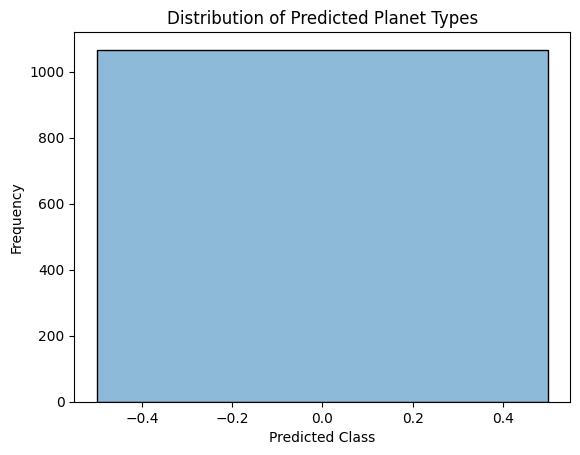

In [72]:
# --- Question 2: Classification of Planets ---
df_class = df.select('radius', 'mass', 'temperature', 'Discovery_Method')

# Convert string column to numeric
indexer = StringIndexer(inputCol="Discovery_Method", outputCol="Discovery_Method_Index")
df_class = indexer.fit(df_class).transform(df_class)

vector_assembler_class = VectorAssembler(inputCols=['radius', 'mass', 'temperature'], outputCol='features')
df_class_features = vector_assembler_class.transform(df_class)

rf = RandomForestClassifier(labelCol='Discovery_Method_Index', featuresCol='features', numTrees=10)
rf_model = rf.fit(df_class_features)
df_pred = rf_model.transform(df_class_features)

evaluator = MulticlassClassificationEvaluator(labelCol="Discovery_Method_Index", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(df_pred)
print(f"Classification Accuracy: {accuracy}")


#Convert to Pandas for Visualisation
df_pred_pd = df_pred.select("Discovery_Method_Index", "prediction").toPandas()
sns.histplot(data=df_pred_pd, x='prediction', kde=True)
plt.xlabel("Predicted Class")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted Planet Types")
plt.savefig("classification_visualization.png")
plt.show()


# Save classification results
df_pred.toPandas().to_csv("classification_results.csv", index=False)

In [ ]:

#Convert to Pandas for Visualisation
df_orbit_pd = df_orbit.toPandas()

sns.lineplot(data=df_orbit_pd, x='semi_major_axis', y='temperature')
plt.xlabel("Semi-Major Axis")
plt.ylabel("Temperature")
plt.title("Orbit Impact on Habitability")
plt.savefig("orbit_temperature_analysis.png")
plt.show()

#Save the Results
df_orbit_pd.to_csv("orbit_temperature_analysis.csv", index=False)

Q1 & Q2: Classify planets by insolation, temperature, mass, coordinates with regards of available planets (Iarsolav)
Complete dataset, it'll be helpful to draw graphics with stars located across sphere (Iarsolav)

In [ ]:
#Export CSV and visualisations

# Patrick
Question 1: Can we identify groups of similar exoplanets?
Analysis: Apply clustering algorithms (e.g., K-means, hierarchical clustering) to group planets with similar characteristics.
Question 2: Can we classify planets into different categories (e.g., rocky planets, gas giants) based on their properties?
Analysis: Use supervised learning algorithms to classify planets based on features such as mass, radius, and temperature.

In [ ]:
#Export CSV and visualisations

# Amrit
Is there a correlation between specific discovery facilities and the methods they use to detect exoplanets, and how does this impact the types of planets discovered?
2. How does the distance of a planet host from its exoplanets influence the exoplanets' temperature, luminosity, and color, and what patterns emerge across different star-planet systems?

In [ ]:
#Export CSV and visualisations